# Graph net for link prediction

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [28]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

import torch_geometric.nn as gnn

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import QualityFocalLoss
from reco.datasetPU import TracksterGraph


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [29]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    pileup=False,
    radius=100,
    bigT_e_th=10,
    link_prediction=True
)

In [31]:
# something is wrong with the shapes!
# TODO: the edge index is wrong duuuuh! the indexes must be into the dataset
ds.data.edge_index.shape[1] == ds.data.x.shape[0]
ds.data.x.shape

torch.Size([28464, 39])

In [32]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)

Train graphs: 899, Test graphs: 99, total: 998


In [80]:
class LinkPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(LinkPredictionNet, self).__init__()
        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 32
        hdim2 = 32
        hdim3 = 32

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2)
        # self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(2 * hdim3, hdim_fc),
            nn.Sigmoid(),
            # nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
        )

    def forward(self, X, edge_index, batch=None):
        H0 = self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch=batch)
        H2 = self.edgeconv2(H1, batch=batch)
        # H3 = self.edgeconv3(H2, batch)
        
        H3 = H2

        src, dst = edge_index
        edges = torch.cat([H3[src], H3[dst]], dim=-1)
        return self.nodenetwork(edges).squeeze(-1)

In [81]:
def train_link_prediction(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.edge_index, batch=data.batch)        
        loss = loss_func(data.y, seg_pred)
        
        loss.backward()
        
        optimizer.step()
        train_loss.append(loss.item())

    return np.mean(train_loss)

In [82]:
@torch.no_grad()
def test_link_prediction(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.edge_index, data.batch)
        loss = loss_func(data.y, seg_pred)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [83]:
model = LinkPredictionNet(input_dim=ds.data.x.shape[1])
epochs = 20
model_path = f"models/LinkPredictionNet.DGCNN.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [84]:
#%%script echo skipping
# alpha - percentage of negative edges
loss_func = QualityFocalLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_link_prediction(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 2 == 0:
        test_loss = test_link_prediction(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 0.191	 validation loss: 0.159
Epoch 2:	 train loss: 0.140	 validation loss: 0.113
Epoch 4:	 train loss: 0.071	 validation loss: 0.069
Epoch 6:	 train loss: 0.065	 validation loss: 0.075
Epoch 8:	 train loss: 0.061	 validation loss: 0.062
Epoch 10:	 train loss: 0.059	 validation loss: 0.064
Epoch 12:	 train loss: 0.054	 validation loss: 0.060
Epoch 14:	 train loss: 0.053	 validation loss: 0.056
Epoch 16:	 train loss: 0.050	 validation loss: 0.054
Epoch 18:	 train loss: 0.050	 validation loss: 0.056


models/LinkPredictionNet.DGCNN.ns.20e-CloseByTwoPion.r100.e10.f10.pt


In [85]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


0.926435682176706


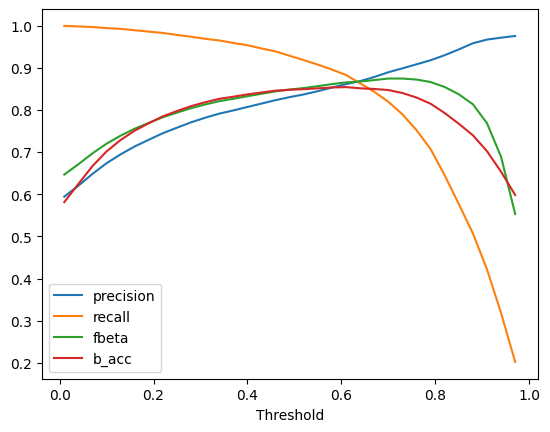

TP: 5546, TN: 5102, FP: 626, FN: 1479
TH: 0.73 precision: 0.899 recall: 0.789 fbeta: 0.874 b_acc: 0.840


In [86]:
#%%script echo skipping
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

## Eval

In [13]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

file_name = f"{raw_dir}/new_ntuples_15643817_2.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=True)

FileNotFoundError: file not found

    '/Users/ecuba/data/CloseByTwoPion/new_ntuples_15643817_2.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [ ]:
result = model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    model,
    decision_th=0.5,
    radius=15,
    max_events=10,
    bigT_e_th=5,
    graph=True,
    pileup=True,
)

Event 0:
	clue3d_to_sim:	P: 0.802 R: 0.307 F: 0.607
	target_to_sim:	P: 0.718 R: 0.727 F: 0.720
	reco_to_sim:	P: 0.552 R: 0.672 F: 0.572
	|S| = 1 |T| = 2 |R| = 2
Event 1:
	clue3d_to_sim:	P: 0.993 R: 0.335 F: 0.713
	target_to_sim:	P: 0.992 R: 0.797 F: 0.946
	reco_to_sim:	P: 0.992 R: 0.797 F: 0.946
	|S| = 1 |T| = 1 |R| = 1
Event 2:
	clue3d_to_sim:	P: 0.955 R: 0.221 F: 0.573
	target_to_sim:	P: 0.925 R: 0.430 F: 0.752
	reco_to_sim:	P: 0.923 R: 0.432 F: 0.752
	|S| = 1 |T| = 2 |R| = 2
Event 3:
	clue3d_to_sim:	P: 0.976 R: 0.793 F: 0.933
	target_to_sim:	P: 0.960 R: 0.823 F: 0.929
	reco_to_sim:	P: 0.893 R: 0.794 F: 0.871
	|S| = 1 |T| = 2 |R| = 2
Event 4:
	clue3d_to_sim:	P: 0.727 R: 0.595 F: 0.696
	target_to_sim:	P: 0.687 R: 0.691 F: 0.687
	reco_to_sim:	P: 0.727 R: 0.595 F: 0.696
	|S| = 1 |T| = 1 |R| = 1
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.511 F: 0.839
	target_to_sim:	P: 1.000 R: 0.566 F: 0.867
	reco_to_sim:	P: 1.000 R: 0.566 F: 0.867
	|S| = 1 |T| = 1 |R| = 1
Event 6:
	clue3d_to_sim:	P: 0.971 

## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796